# Principal Patterns Paper Plots - Base Case

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pypsa
import os
import sys
import geopandas
import vresutils
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
import tables
from operator import itemgetter, attrgetter
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from sklearn.preprocessing import Normalizer

## Helpers

In [2]:
tech_colors = {"onwind":"b","onshore wind":"b",'wind':'b','offwind':"c",'offshore wind':"c",'offwind-ac':"c",'offshore wind (AC)':"c",'offwind-dc':"#009999",'offshore wind (DC)':"#009999",
               'wave':"#004444","hydro":"#3B5323","hydro reservoir":"#3B5323","hydro dam":"#3B5323","ror":"#78AB46","run of river":"#78AB46",'hydroelectricity':'#006400','solar PV':"y",
               'solar thermal':'coral','solar rooftop':'#e6b800',"OCGT":"wheat","OCGT marginal":"sandybrown","OCGT-heat":"orange","gas boiler":"orange","gas boilers":"orange",
               "gas boiler marginal":"orange","gas-to-power/heat":"orange","gas":"brown","natural gas":"brown","SMR":"#4F4F2F","oil":"#B5A642","oil boiler":"#B5A677","lines":"k",
               "transmission lines":"k","H2":"m","hydrogen storage":"m","battery":"slategray","battery storage":"slategray","home battery":"#614700","home battery storage":"#614700",
               "Nuclear":"r","Nuclear marginal":"r","nuclear":"r","uranium":"#ff5055",
               "Lignite marginal":"grey","CCGT":"orange","CCGT marginal":"orange","heat pumps":"#76EE00","heat pump":"#76EE00","air heat pump":"#76EE00","ground heat pump":"#40AA00",
               "power-to-heat":"#40AA00","resistive heater":"pink","Sabatier":"#FF1493","methanation":"#FF1493","power-to-gas":"#FF1493","power-to-liquid":"#FFAAE9","helmeth":"#7D0552",
               "helmeth":"#7D0552","DAC":"#E74C3C","co2 stored":"#123456","CO2 sequestration":"#123456","CC":"k","co2":"#123456","co2 vent":"#654321",
               "solid biomass for industry co2 from atmosphere":"#654321","solid biomass for industry co2 to stored": "#654321","gas for industry co2 to atmosphere":"#654321",
               "gas for industry co2 to stored":"#654321","Fischer-Tropsch":"#44DD33","kerosene for aviation":"#44BB11","naphtha for industry":"#44FF55","land transport oil":"#44DD33",
               "water tanks":"#BBBBBB","hot water storage":"#BBBBBB","hot water charging":"#BBBBBB","hot water discharging":"#999999","CHP":"r","CHP heat":"r","CHP electric":"r",
               "PHS":"g","Ambient":"k","Electric load":"b","Heat load":"r","heat":"darkred","rural heat":"#880000","central heat":"#b22222","decentral heat":"#800000",
               "low-temperature heat for industry":"#991111","process heat":"#FF3333","heat demand":"darkred","electric demand":"k","Li ion":"grey","district heating":"#CC4E5C",
               "retrofitting":"purple","building retrofitting":"purple","BEV charger":"grey","V2G":"grey","land transport EV":"grey","electricity":"k",
               "solid biomass for industry":"#555555","industry electricity":"#222222","industry new electricity":"#222222","process emissions to stored":"#444444",
               "process emissions to atmosphere":"#888888","process emissions":"#222222","oil emissions":"#666666","land transport oil emissions":"#878787",
               "land transport fuel cell":"#AAAAAA","today":"#D2691E","shipping":"#6495ED","electricity distribution grid":"#333333",
             "gas for industry":"brown",#"gas for industry":"#333333",
             "land conventional":"#44DD33","land EV":"grey","land hydrogen":"#AAAAAA",
             "aviation kerosene":"#44BB11","shipping hydrogen":"#6495ED",
             "naphtha":"#44FF55","hydrogen":"m",
             "carbon capture":"#BE7B74",
             "other":"#889977","biogas":"#EA3A85","solid biomass":"#E1AC87",
             'solar':"#F3E143", "Coal":"#8A7D6E","coal":"#8A7D6E","Coal marginal":"#8A7D6E","Lignite":"#8C6E4C","lignite":"#8C6E4C",
             ' ':(0,0,0,0)}

In [3]:
def rename_techs(label):
    prefix_to_remove = ["residential ","services ","urban ","rural ","central ","decentral "]
    rename_if_contains = ["CHP","gas boiler","biogas","solar thermal","air heat pump","ground heat pump","resistive heater","Fischer-Tropsch"]
    rename_if_contains_dict = {"water tanks" : "hot water storage",
                               "retrofitting" : "building retrofitting",
                               "H2" : "hydrogen storage",
                               "battery" : "battery storage",
                               "CC" : "CC"}
    rename = {"solar" : "solar PV",
              "Sabatier" : "methanation",
              "offwind" : "offshore wind",
              "offwind-ac" : "offshore wind (AC)",
              "offwind-dc" : "offshore wind (DC)",
              "onwind" : "onshore wind",
              "ror" : "hydroelectricity",
              "hydro" : "hydroelectricity",
              "PHS" : "hydroelectricity",
              "co2 Store" : "DAC",
              "co2 stored" : "CO2 sequestration",
              "AC" : "transmission lines",
              "DC" : "transmission lines",
              "B2B" : "transmission lines",
              "solid biomass for industry" : "solid biomass"}
    for ptr in prefix_to_remove:
        if label[:len(ptr)] == ptr:
            label = label[len(ptr):]
    for rif in rename_if_contains:
        if rif in label:
            label = rif
    for old,new in rename_if_contains_dict.items():
        if old in label:
            label = new
    for old,new in rename.items():
        if old == label:
            label = new
    return label

In [4]:
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    elif tech in ["methanation", "hydrogen storage", "helmeth"]:
        return "power-to-gas"
    elif tech in ["OCGT", "CCGT", "CHP", "gas boiler", "gas for industry"]:
        return "gas"
    elif tech in ["oil boiler"]:
        return "oil"
    elif "solar" in tech:
        return "solar"
    elif tech == "Fischer-Tropsch":
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif tech in ["DAC", "CC"]:
        return "carbon capture"
    elif tech in ['electricity distribution grid','transmission lines']:
        return "transmission lines"
    elif tech in ['uranium','nuclear']:
        return "nuclear"
    #elif tech in ["solid biomass for industry","solid biomass","biogas"]:
    #    return "biomass"
    elif tech in ["BEV charger","V2G","process emissions"]:
        return "other"
    else:
        return tech

In [5]:
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (72./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

In [6]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                names = ifind.index[ifind == i]
                c.df.loc[names, 'location'] = 'EU'
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, 'location'] = names.str[:i]

## Load network file

In [7]:
n = pypsa.Network('../data/postnetwork-elec_only_0.125_0.05.h5')
line_limit = 0.125

# Drop non-electric buses so they don't clutter the plot
n.buses.drop(n.buses.index[n.buses.index.str.len() != 2],inplace=True)

assign_location(n)

Importing PyPSA from older version of PyPSA than current version 0.14.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network postnetwork-elec_only_0.125_0.05.h5 has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


## Plot

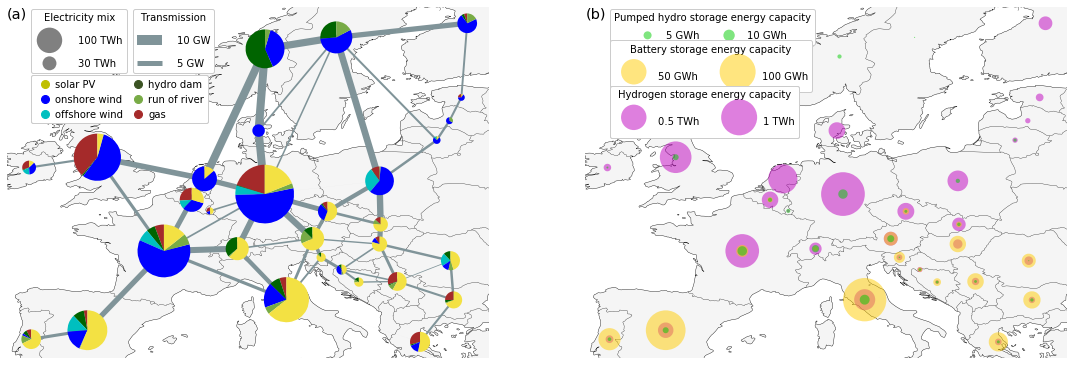

In [8]:
## Plot the electricity mix map.
## plot_electricity_generation. Original source: https://github.com/martavp/PyPSA-plots/blob/master/scripts/2_plot_spatial_storage.py
fig, axes = plt.subplots(1, 2, figsize=(19,7), subplot_kw={"projection":ccrs.PlateCarree()}, )
n.buses.loc["NO",["x","y"]] = [10.4,62.5]
n.buses.loc["SE",["x","y"]] = [16, 63.4]

## Panel (a):
ax = axes[0]
primary = pd.DataFrame(index=n.buses.index)
primary["gas"] = n.stores_t.p[n.stores.index[n.stores.index.str[3:] == "gas Store"]].sum().rename(lambda x : x[:2])
primary["hydroelectricity"] = n.storage_units_t.p[n.storage_units.index[n.storage_units.index.str[3:] == "hydro"]].sum().rename(lambda x : x[:2]).fillna(0.)
n.generators["country"] = n.generators.index.str[:2]
for tech in ["onwind", "offwind", "solar", "ror"]:
    primary[tech] = n.generators_t.p[n.generators.index[n.generators.carrier == tech]].sum(axis=0).rename(lambda x : x[:2]).fillna(0.).groupby(level=0).sum()
primary[primary < 0.] = 0.
primary = primary.fillna(0.)
primary = primary.stack().sort_index()
line_widths_exp = pd.concat(dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt))
line_widths_exp = np.sqrt(line_widths_exp) * 90
linewidth_factor = 1e3
line_color = (0.5,0.58,0.6)
bus_size_factor = 1e8

n.plot(bus_sizes=primary/bus_size_factor, bus_colors=tech_colors, line_colors=dict(Line=line_color, Link=line_color),
       line_widths=line_widths_exp/linewidth_factor, ax=ax, geomap='50m', color_geomap={'ocean': 'white', 'land': 'whitesmoke'})

handles = make_legend_circles_for([1e8, 3e7], scale=bus_size_factor, facecolor="gray")
labels = ["{} TWh".format(s) for s in (100, 30)]
l2 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.04, 1.01), labelspacing=1.3, handletextpad=1.5, handlelength=2.8,
               framealpha=1., facecolor='white', title='Electricity mix', handler_map=make_handler_map_to_scale_circles_as_in(ax))
ax.add_artist(l2)
handles = []; labels = []
for s in (10, 5):
    handles.append(plt.Line2D([0],[0], color=line_color, linewidth=s*1e3/linewidth_factor, solid_capstyle='butt'))
    labels.append("{} GW".format(s))
l1 = l1_1 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.25, 1.01), framealpha=1, 
                      facecolor='white', labelspacing=1.3, handletextpad=1.5, title='Transmission', handlelength=2.5)
ax.add_artist(l1_1)
techs = primary.index.levels[1]
techs = ['solar PV', 'onshore wind', 'offshore wind', 'hydro dam', 'run of river', 'gas']
handles = []; labels = []
for t in techs:
    handles.append(plt.Line2D([0], [0], color=tech_colors[t], marker='o', markersize=8, linewidth=0))
    labels.append(t)
l3 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.04, 0.82), framealpha=1.,
               facecolor='white', handletextpad=0., columnspacing=0.5, ncol=2, title=None)
ax.add_artist(l3);
ax.text(0.0, 0.97, '(a)', fontsize=14.5, transform=ax.transAxes);

## Panel (b):
ax = axes[1]
dic_storage={'H2':'H2 Store', 'battery':'battery', 'PHS':'PHS'}
dic_scale={'H2':1., 'battery':10., 'PHS':10.}
dic_col={'H2':[0.75, 0., 0.75,  0.5], 'battery':[1., 0.8, 0.,  0.5], 'PHS':[0., 0.8, 0.,  0.5]}
for storage_tech in ['H2', 'battery', 'PHS']:
    storage = pd.DataFrame(index=n.buses.index)
    if storage_tech=='PHS':
        storage[storage_tech] = n.storage_units.p_nom[n.storage_units.index[n.storage_units.carrier == 'PHS']].rename(lambda x : x[:2])
    else:
        storage[storage_tech] = n.stores.e_nom_opt[n.stores.index[n.stores.index.str[3:] == dic_storage[storage_tech]]].rename(lambda x : x[:2])
    storage[storage < 0.] = 0.
    storage = storage.fillna(0.)
    storage = storage.stack().sort_index()
    bus_size_factor = 5e5/dic_scale[storage_tech]
    n.buses.loc["NO",["x","y"]] = [10.1,61.9]
    line_widths_exp = pd.concat(dict(Line=n.lines.s_nom_opt, Link=n.links.p_nom_opt))
    n.plot(bus_sizes=storage/bus_size_factor, bus_colors=dic_col, line_colors=dict(Line=(0,0,0,0), Link=(0,0,0,0)),
           line_widths=0, ax=ax, geomap=('50m' if storage_tech=='H2' else False), color_geomap={'ocean': 'white', 'land': 'whitesmoke'})     
storage_tech='battery'
handles = make_legend_circles_for([5e4, 1e5], scale=5e5/dic_scale[storage_tech], facecolor=dic_col[storage_tech])
labels = ["{} GWh".format(s) for s in (50, 100)] 
storage_tech='H2'
handles2 = make_legend_circles_for([5e5, 1e6], scale=5e5/dic_scale[storage_tech], facecolor=dic_col[storage_tech])
labels2 = ["{} TWh".format(s) for s in (0.5, 1)]  
storage_tech='PHS'
handles3 = make_legend_circles_for([5e3, 1e4], scale=5e5/dic_scale[storage_tech], facecolor=dic_col[storage_tech])
labels3 = ["{} GWh".format(s) for s in (5, 10)]

l3 = ax.legend(handles3, labels3, loc="upper left", bbox_to_anchor=(0.04, 1.01), labelspacing=0.8,
               ncol=2, framealpha=1., title='Pumped hydro storage energy capacity', handler_map=make_handler_map_to_scale_circles_as_in(ax))
ax.add_artist(l3);
l1 = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.04, 0.92), labelspacing=1., handletextpad=0.4, handlelength=4, handleheight=3.3,
               ncol=2, framealpha=1., title='Battery storage energy capacity', handler_map=make_handler_map_to_scale_circles_as_in(ax))
ax.add_artist(l1)
l2 = ax.legend(handles2, labels2, loc="upper left", bbox_to_anchor=(0.04, 0.79), labelspacing=1., handletextpad=0.4, handlelength=4, handleheight=3.3,
               ncol=2, framealpha=1., title='Hydrogen storage energy capacity', handler_map=make_handler_map_to_scale_circles_as_in(ax))
ax.add_artist(l2);
ax.text(0.0, 0.97, '(b)', fontsize=14.5, transform=ax.transAxes);